   month  cum_borrower_defaults  cum_bank_defaults
0      0                      6                  0
1      1                     13                  0
2      2                     20                  0
3      3                     23                  0
4      4                     28                  0


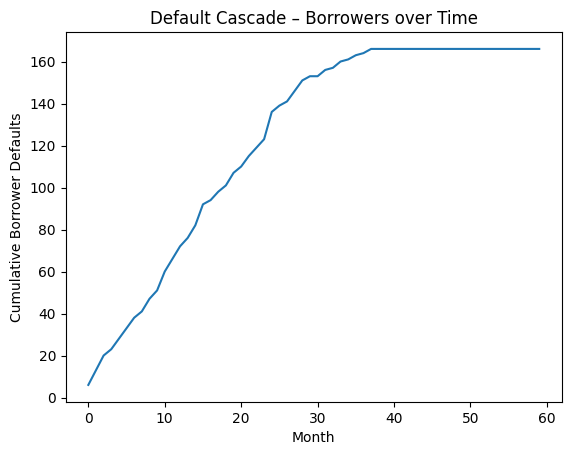

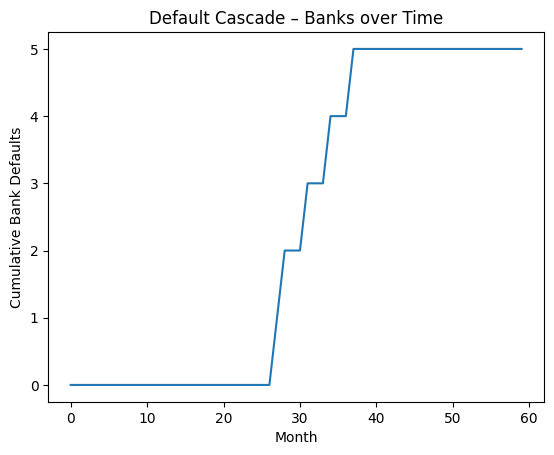

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
import random

# --- Agent Definitions -------------------------------------------------------


@dataclass
class Borrower:
    id: str
    pd_month: float     # monthly probability of default
    lgd: float = 0.55   # loss‑given‑default
    ead: float = 100.0  # exposure at default
    defaulted: bool = False

    def step(self, macro_factor: float = 1.0) -> float:
        """
        One-month transition for the borrower.
        Returns the credit loss suffered this month (0 if still performing).
        """
        if self.defaulted:
            return 0.0

        # Bernoulli trial for default (PD adjusted by macro factor)
        if np.random.rand() < self.pd_month * macro_factor:
            self.defaulted = True
            return self.lgd * self.ead
        return 0.0


@dataclass
class Bank:
    id: str
    capital: float
    borrowers: list
    defaulted: bool = False

    def step(self, macro_factor: float = 1.0):
        """
        Propagate one step for all borrowers, deduct losses from capital.
        """
        if self.defaulted:
            return

        # Aggregate borrower losses
        loss = sum(b.step(macro_factor) for b in self.borrowers)
        self.capital -= loss

        # Fire‑sale feedback: if capital < 0 the bank defaults
        if self.capital < 0.0:
            self.defaulted = True


# --- Simulation --------------------------------------------------------------
def build_system(n_banks: int = 5, borrowers_per_bank: int = 120):
    """
    Helper to create a sample banking system.
    """
    banks = []
    for i in range(n_banks):
        borrowers = [
            Borrower(
                id=f"B{i}_{j}",
                pd_month=np.random.uniform(
                    0.004, 0.015),  # 0.4–1.5 % per month
            )
            for j in range(borrowers_per_bank)
        ]
        # simple 15 % capital ratio on EAD
        total_ead = sum(b.ead for b in borrowers)
        bank_capital = 0.15 * total_ead
        banks.append(
            Bank(id=f"Bank{i}", capital=bank_capital, borrowers=borrowers))
    return banks


def run_simulation(
    months: int = 60,
    shock_month: int = 24,
    shock_multiplier: float = 3.0,
    n_banks: int = 5,
    borrowers_per_bank: int = 120,
):
    """
    Simulate credit dynamics over 'months' months.
    Returns a DataFrame with cumulative defaults.
    """
    banks = build_system(n_banks, borrowers_per_bank)

    results = {
        "month": [],
        "cum_borrower_defaults": [],
        "cum_bank_defaults": [],
    }

    for t in range(months):
        # Macro shock: PDs triple for 1 month
        macro = shock_multiplier if t == shock_month else 1.0

        # step each bank
        for bank in banks:
            bank.step(macro_factor=macro)

        # collect stats
        cum_borrower_defaults = sum(
            sum(b.defaulted for b in bank.borrowers) for bank in banks
        )
        cum_bank_defaults = sum(bank.defaulted for bank in banks)

        results["month"].append(t)
        results["cum_borrower_defaults"].append(cum_borrower_defaults)
        results["cum_bank_defaults"].append(cum_bank_defaults)

    return pd.DataFrame(results)


# --------------------- run & visualise ---------------------------------------
df = run_simulation()

# --- inspect results (local Python) ---
print(df.head())                 # schnelle Kontrolle im Terminal
# df.to_csv("simulation_results.csv", index=False)   # optional: Datei speichern

# Plot cumulative borrower defaults
fig, ax = plt.subplots()
ax.plot(df["month"], df["cum_borrower_defaults"])
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative Borrower Defaults")
ax.set_title("Default Cascade – Borrowers over Time")
plt.show()

# Plot cumulative bank defaults
fig2, ax2 = plt.subplots()
ax2.plot(df["month"], df["cum_bank_defaults"])
ax2.set_xlabel("Month")
ax2.set_ylabel("Cumulative Bank Defaults")
ax2.set_title("Default Cascade – Banks over Time")
plt.show()
